In [ ]:
""" PLEASE DO NOT DIRECTLY EDIT THIS FILE.

    This file contains a working version of the U-Net as described here: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    Many of the functions have been copied and slightly modified with comments from https://github.com/milesial/Pytorch-UNet
    The new functions are for the Dataset class and for the create_npy_list function. 
    
    The original U-Net file structure was split into multiple module files. For this working draft, 
    all functions have been incorporated into this single file in seperate cells along with their package dependancies
    so that splitting into seperate modules in the future, if desired, will be simple.
    
    Additionally, this version has been slightly adapted for the single band SAR tile input compared to
    the original 3 band optical image (RGB) input of U-NET. 
    
    To adjust, must change: dir_image, dir_checkpoint, n_channels, n_classes and bilinear variables.
"""

In [1]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => BatchNorm => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [2]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
""" CNN Dataset preparation functions """

import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import glob
import numpy as np
torch.manual_seed(2022)  # Setting random seed so that augmentations can be reproduced.
# From https://discuss.pytorch.org/t/beginner-how-do-i-write-a-custom-dataset-that-allows-me-to-return-image-and-its-target-image-not-label-as-a-pair/13988/4
# And https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881


def create_npy_list(image_directory, img_string="sar"):
    """A function that returns a list of the names of the SAR/MODIS and labelled .npy files in a directory. These lists can
    then be used as an argument for the Dataset class instantiation. The function also checks that the specified directory 
    contains matching sar or MODIS/labelled pairs -- specifically, a label.npy file for each image file."""

    img_names = sorted(glob.glob(str(image_directory) + '/*_' + img_string + '.npy'))
    label_names = sorted(glob.glob(str(image_directory) + '/*_labels.npy'))

    # In-depth file-by-file check for matching sar-label pairs in the directory -- assuming  each sar image has a corresponding
    # labeled image.
    img_label_pairs = []
    for image in img_names:
        expected_label_name = image.replace(img_string, "labels")
        if expected_label_name in label_names:
            img_label_pairs.append((image, expected_label_name))
        else:
            raise Exception(f'{img_string} tile name {image} does not have a matching labeled tile.')
            
    return img_label_pairs


class CustomImageDataset(Dataset):
    """GTC Code for a dataset class. The class is instantiated with list of filenames within a directory (created using
    the list_npy_filenames function). The __getitem__ method pairs up corresponding image-label .npy file pairs. This
    dataset can then be input to a dataloader."""
    
    def __init__(self, paths, isSingleBand = True):
        self.paths = paths
        self.isSingleBand = isSingleBand
    
    def __getitem__(self, index):
        image = torch.from_numpy(np.vstack(np.load(self.paths[index][0])).astype(float))
        if self.isSingleBand:
            image = image[None,:]
        else:
            image = torch.permute(image, (2,0,1))
        mask_raw = (np.load(self.paths[index][1]))
        maskremap100 = np.where(mask_raw == 100, 0, mask_raw)
        maskremap200 = np.where(maskremap100 == 200, 1, maskremap100)
        mask = torch.from_numpy(np.vstack(maskremap200).astype(float))
        
        #assert image.size == mask.size, \
        #    'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'
        
        return {
            'image': image,
            'mask': mask
        }

    def __len__(self):
        return len(self.paths) 
    
    
class CustomImageAugmentDataset(Dataset):
    """GTC Code for an augmented dataset class. The class is instantiated with a list of filenames within a directory 
    (created using the list_npy_filenames function). The __getitem__ method pairs up corresponding image-label .npy file
    pairs. If specified, augmentations are also applied to the images with a probability. There is a ~25% chance that 
    no augmentations are applied and a 20% chance of each of the following augmentations: horizontal flip, vertical 
    flip, 90 degree rotation (anti-clockwise & clockwise), 180 degree rotation, random crop. Multiple augmentations are
    applied in sequence. This dataset can then be input to a dataloader."""

    def __init__(self, paths, augmentation):
        self.paths = paths
        self.augmentation = augmentation

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image = torch.from_numpy(np.vstack(np.load(self.paths[index][0])).astype(float))[None, :]
        mask_raw = (np.load(self.paths[index][1]))
        maskremap100 = np.where(mask_raw == 100, 100, mask_raw) # 0
        maskremap200 = np.where(maskremap100 == 200, 200, maskremap100) # 1
        mask = torch.from_numpy(np.vstack(maskremap200).astype(float))

        if self.augmentation:
            image_pair = self.augment_image(image, mask)
        else:
            image_pair = {'image': image, 'mask': mask}

        return image_pair

    @staticmethod
    def augment_image(original_image, original_mask):

        augmented_image = original_image
        augmented_mask = original_mask

        aug_probabilities = np.random.choice(a=[0, 1], size=4, p=[0.75, 0.25])

        if aug_probabilities[0]: # Horizontal flip
            augment_function = transforms.RandomHorizontalFlip(p=1)
            augmented_image, augmented_mask = augment_function(augmented_image), augment_function(augmented_mask)

        if aug_probabilities[1]: # Vertical flip
            augment_function = transforms.RandomVerticalFlip(p=1)
            augmented_image, augmented_mask = augment_function(augmented_image), augment_function(augmented_mask)

        if  avg_probabilities[2]: # Rotations
            rotations = np.random.choice(a=[1, 2, 3], size=1)
            augmented_image = torch.rot90(augmented_image, k=rotations, dims=[1, 2])
            augmented_mask = torch.rot90(augmented_mask, k=rotations, dims=[0, 1])

        if aug_probabilities[3]: # Random crop (and resize)
            augment_function = transforms.Compose([transforms.RandomCrop(size=256),
                                                   transforms.Resize(512)])
            augmented_image, augmented_mask = augment_function(augmented_image), augment_function(augmented_mask)

        """
        if aug_probabilities[6]: # Gaussian blur
            augment_function = transforms.GaussianBlur(kernel_size=(7,13), sigma=(0.1, 0.2))
            augmented_image, augmented_mask = augment_function(augmented_image), augment_function(augmented_mask)
        """
        return {'image': augmented_image, 'mask': augmented_mask}
    

In [5]:
""" Dice Loss scoring functions """

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [6]:
""" Model evaluation functions """

import torch
import torch.nn.functional as F
from tqdm import tqdm


def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

           

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches

In [ ]:
""" Implementation of model """

import argparse
import logging
import sys
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


dir_img = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/tiled/')
dir_checkpoint = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/model/checkpoints/unet_orig')


def train_net(net,
              device,
              epochs: int = 1,
              batch_size: int = 20,
              learning_rate: float = 0.001,
              val_percent: float = 0.1,
              save_checkpoint: bool = True,
              img_scale: float = 0.5,
              amp: bool = False):
    # 1. Create dataset
    img_list = create_npy_list(dir_img)
    dataset = CustomImageDataset(img_list, True)
    
    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    
    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
    
    # Initialize logging
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                  val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale,
                                  amp=amp))

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0
    
    # 5. Begin training
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']
                
                assert images.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels of {images.shape}. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks) \
                           + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                       F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                                       multiclass=True)
                # change number for permute?
                
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (10 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in net.named_parameters():
                            tag = tag.replace('/', '.')
                            histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(net, val_loader, device)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(torch.softmax(masks_pred, dim=1).argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))
            logging.info(f'Checkpoint {epoch + 1} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=0.00001,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')

    return parser.parse_args()


if __name__ == '__main__':
    args = get_args()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net = UNet(n_channels=1, n_classes=2, bilinear=True)

    logging.info(f'Network:\n'
                 f'\t{net.n_channels} input channels\n'
                 f'\t{net.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

#    if args.load:
#        net.load_state_dict(torch.load(args.load, map_location=device))
#        logging.info(f'Model loaded from {args.load}')

    net.to(device=device)
    try:
        train_net(net=net,
                  epochs=args.epochs,
                  batch_size=args.batch_size,
                  learning_rate=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100,
                  amp=args.amp)
    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        sys.exit(0)

INFO: Using device cpu
INFO: Network:
	1 input channels
	2 output channels (classes)
	Bilinear upscaling
wandb: Currently logged in as: mlisaius (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


INFO: Starting training:
        Epochs:          5
        Batch size:      1
        Learning rate:   1e-05
        Training size:   1669
        Validation size: 185
        Checkpoints:     True
        Device:          cpu
        Images scaling:  0.5
        Mixed Precision: False
    
Epoch 1/5:   0%|                                                                              | 0/1669 [00:00<?, ?img/s]/home/mlisaius/miniconda3/envs/unetenv/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Validation round:  31%|███████████████████                                          | 58/185 [02:19<05:06,  2.41s/batch]


Validation round:  67%|████████████████████████████████████████▏                   | 124/185 [04:51<02:20,  2.31s/batch]


Validation round: 100%|████████████████████████████████████████████████████████████| 185/185 [07:01<00:00,  2.11s/batch]
                                                                                                                        INFO: Validation Dice score: 0.7039704918861389
Validation round:   1%|▎                                                             | 1/185 [00:02<07:46,  2.54s/batch]


Validation round:  36%|██████████████████████                                       | 67/185 [02:04<03:41,  1.88s/batch]


Validation round:  72%|███████████████████████████████████████████▏                | 133/185 [04:09<01:43,  1.98s/batch]


Validation round: 100%|████████████████████████████████████████████████████████████| 185/185 [05:48<00:00,  1.94s/batch]
                                                                                                                        INFO: Validation Dice score: 0.7030525803565979
Validation round:   5%|███▎                                                         | 10/185 [00:21<06:06,  2.10s/batch]


Validation round:  41%|█████████████████████████                                    | 76/185 [02:36<03:45,  2.07s/batch]


Validation round:  77%|██████████████████████████████████████████████              | 142/185 [05:00<01:31,  2.12s/batch]


Validation round: 100%|████████████████████████████████████████████████████████████| 185/185 [06:39<00:00,  1.91s/batch]
                                                                                                                        INFO: Validation Dice score: 0.7043184638023376
Validation round:  10%|██████▎                                                      | 19/185 [00:38<05:26,  1.97s/batch]


Validation round:  46%|████████████████████████████                                 | 85/185 [02:56<03:19,  1.99s/batch]


Validation round:  82%|████████████████████████████████████████████████▉           | 151/185 [05:55<01:09,  2.04s/batch]


Validation round: 100%|████████████████████████████████████████████████████████████| 185/185 [07:28<00:00,  2.29s/batch]
                                                                                                                        INFO: Validation Dice score: 0.704319953918457
Validation round:  15%|█████████▏                                                   | 28/185 [01:18<06:07,  2.34s/batch]


Validation round:  51%|██████████████████████████████▉                              | 94/185 [03:52<03:05,  2.04s/batch]


Validation round:  86%|███████████████████████████████████████████████████▉        | 160/185 [06:15<00:56,  2.27s/batch]


Validation round: 100%|████████████████████████████████████████████████████████████| 185/185 [07:13<00:00,  2.31s/batch]
                                                                                                                        INFO: Validation Dice score: 0.2486787736415863
Epoch 1/5:  58%|█████████████████████████▍                  | 964/1669 [2:31:20<1:40:16,  8.53s/img, loss (batch)=0.974]

In [8]:
import torch
#from unet import UNet as _UNet

def unet_pretrained(pretrained=False):
    """
    UNet model trained on the Carvana dataset ( https://www.kaggle.com/c/carvana-image-masking-challenge/data ).
    Set the scale to 0.5 (50%) when predicting.
    """
    net = UNet(n_channels=1, n_classes=2, bilinear=True)
    if pretrained:
        #checkpoint = # input checkpoint dir 'https://github.com/milesial/Pytorch-UNet/releases/download/v2.0/unet_carvana_scale0.5_epoch1.pth'
        checkpoint = str(dir_checkpoint) + "/checkpoint_epoch1.pth" 
        net.load_state_dict(torch.load(checkpoint, map_location=device))
        #net.load_state_dict(torch.hub.load(checkpoint, 'checkpoint_epoch1'))
        # Use when loading from a git repository
        #net.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=True))

    return net

#test_net = unet_pretrained(True)

In [41]:
""" Prediction plotting function """

import matplotlib.pyplot as plt


def plot_img_and_mask(img, mask):
    classes = mask.shape[0] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i + 1].set_title(f'Output mask (class {i + 1})')
            #ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].imshow(mask[i, :, :])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
#import predict

In [37]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

#from utils.data_loading import BasicDataset
#from unet import UNet
#from utils.utils import plot_img_and_mask

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = full_img #torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)[0]
        else:
            probs = torch.sigmoid(output)[0]

        tf = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((full_img.size[1], full_img.size[0])),
            transforms.ToTensor()
        ])

        full_mask = tf(probs.cpu()).squeeze()

    if net.n_classes == 1:
        return (full_mask > out_threshold).numpy()
    else:
        return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()


def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images')
    parser.add_argument('--model', '-m', default='MODEL.pth', metavar='FILE',
                        help='Specify the file in which the model is stored')
    parser.add_argument('--input', '-i', metavar='INPUT', nargs='+', help='Filenames of input images', required=True)
    parser.add_argument('--output', '-o', metavar='INPUT', nargs='+', help='Filenames of output images')
    parser.add_argument('--viz', '-v', action='store_true',
                        help='Visualize the images as they are processed')
    parser.add_argument('--no-save', '-n', action='store_true', help='Do not save the output masks')
    parser.add_argument('--mask-threshold', '-t', type=float, default=0.5,
                        help='Minimum probability value to consider a mask pixel white')
    parser.add_argument('--scale', '-s', type=float, default=0.5,
                        help='Scale factor for the input images')

    return parser.parse_args()


def get_output_filenames(args):
    def _generate_name(fn):
        split = os.path.splitext(fn)
        return f'{split[0]}_OUT{split[1]}'

    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))


# if __name__ == '__main__':
#     args = get_args()
#     in_files = args.input
#     out_files = get_output_filenames(args)

#     # update n_channels
#     net = UNet(n_channels=1, n_classes=2)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     logging.info(f'Loading model {args.model}')
#     logging.info(f'Using device {device}')

#     net.to(device=device)
#     net.load_state_dict(torch.load(args.model, map_location=device))

#     logging.info('Model loaded!')

#     for i, filename in enumerate(in_files):
#         logging.info(f'\nPredicting image {filename} ...')
#         img = Image.open(filename)

#         mask = predict_img(net=net,
#                            full_img=img,
#                            scale_factor=args.scale,
#                            out_threshold=args.mask_threshold,
#                            device=device)

#         if not args.no_save:
#             out_filename = out_files[i]
#             result = mask_to_image(mask)
#             result.save(out_filename)
#             logging.info(f'Mask saved to {out_filename}')

#         if args.viz:
#             logging.info(f'Visualizing results for image {filename}, close to continue...')
#             plot_img_and_mask(img, mask)

In [8]:
# import numpy as np

# path = Path("/mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/tiled/2011-01-24_134238_tile337_sar.npy")
# this_path = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/tiled/2011-01-24_134238_tile336_sar.npy')
# image = torch.from_numpy(np.vstack(np.load(this_path)).astype(float))[None,:]

# net = UNet(n_channels=1, n_classes=2)

# checkpoint = str(dir_checkpoint) + "/checkpoint_epoch1.pth"
# net.load_state_dict(torch.load(checkpoint))


In [54]:
#prediction = predict_img(net=net,
#                            full_img=image,
#                            #scale_factor=args.scale,
#                            #out_threshold=args.mask_threshold,
#                            device=device)

#this_img = image.numpy().squeeze()
#this_img.shape


#plot_img_and_mask(this_img, prediction)


def make_predictions (dir_test, dir_out, viz = False, save = False):
    img_list = create_npy_list(dir_test)
    
    net = UNet(n_channels=1, n_classes=2)

    checkpoint = str(dir_checkpoint) + "/checkpoint_epoch1.pth"
    net.load_state_dict(torch.load(checkpoint))
    
    for i in enumerate(img_list):
        filename = i[1][0]
        #print(filename)
        logging.info(f'\nPredicting image {filename} ...')
        #img = Image.open(filename)
        img = torch.from_numpy(np.vstack(np.load(filename)).astype(float))[None,:]

        mask = predict_img(net=net,
                            full_img=img,
                            scale_factor=0.5,
                            out_threshold=0.5,
                            device=device)

#         if not args.no_save:
#             out_filename = out_files[i]
#             result = mask_to_image(mask)
#             result.save(out_filename)
#             logging.info(f'Mask saved to {out_filename}')

        if viz:
             logging.info(f'Visualizing results for image {filename}, close to continue...')
             #print(img.size())
             plot_img_and_mask(img.squeeze(), mask)

        if save:
             out_filename = str(dir_out) + "/" + str(filename[-33:-4]) + "_prediction.png"
             print(out_filename)
             result = mask_to_image(mask)
             result.save(out_filename)
             logging.info(f'Mask saved to {out_filename}')
            
            

INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-01-13_021245_tile331_sar.npy ...
INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-01-13_021245_tile331_sar.npy, close to continue...


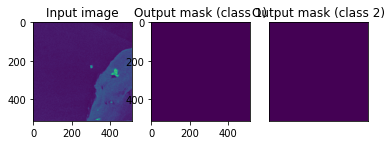

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-01-13_021245_tile331_sar_prediction.png
INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-01-24_134238_tile394_sar.npy ...


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-01-13_021245_tile331_sar_prediction.png


INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-01-24_134238_tile394_sar.npy, close to continue...


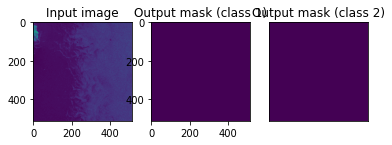

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-01-24_134238_tile394_sar_prediction.png
INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-03-01_033109_tile37_sar.npy ...


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-01-24_134238_tile394_sar_prediction.png


INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-03-01_033109_tile37_sar.npy, close to continue...


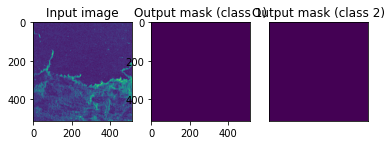

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2011-03-01_033109_tile37_sar_prediction.png
INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-03-13_025215_tile387_sar.npy ...


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2011-03-01_033109_tile37_sar_prediction.png


INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2011-03-13_025215_tile387_sar.npy, close to continue...


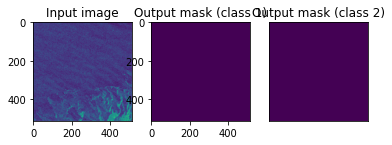

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-03-13_025215_tile387_sar_prediction.png
INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2012-11-14_080243_tile68_sar.npy ...


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/2011-03-13_025215_tile387_sar_prediction.png


INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2012-11-14_080243_tile68_sar.npy, close to continue...


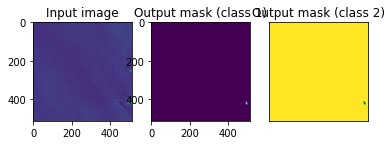

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2012-11-14_080243_tile68_sar_prediction.png
INFO: 
Predicting image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2013-01-31_234751_tile63_sar.npy ...


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2012-11-14_080243_tile68_sar_prediction.png


INFO: Visualizing results for image /mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/2013-01-31_234751_tile63_sar.npy, close to continue...


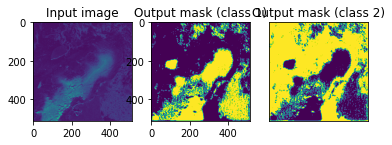

INFO: Mask saved to /mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2013-01-31_234751_tile63_sar_prediction.png


/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles//2013-01-31_234751_tile63_sar_prediction.png


In [55]:
dir_test = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/')
dir_out = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/')

make_predictions(dir_test, dir_out, True, True)

In [45]:
import argparse
import logging
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.colors
#from unet.network_structure import UNet
#from unet.dataset_preparation import create_npy_list

def load_model(model_path, unet_type, image_type):
    if image_type == "modis":
        channels = 3
    elif image_type == "sar":
        channels = 1
    if unet_type == "raw":
        model = UNet(n_channels=channels, n_classes=2, bilinear=True)
#    elif unet_type == "pretrained":
#        model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', decoder_use_batchnorm=True,
#                 decoder_attention_type=None, in_channels=channels, classes=1, encoder_depth=5)
#        model = model.double()
    state = torch.load(model_path)
    model.load_state_dict(state)
    return(model)

def plot_img_and_mask(img, mask, image_type):
    classes = mask.shape[0] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    if image_type == "sar":
            ax[0].imshow(img, cmap='gray')
    elif image_type == "modis":
            ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i + 1].set_title(f'Output mask (class {i + 1})')
            #ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].imshow(mask[i, :, :])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask, cmap = 'blue')
    plt.xticks([]), plt.yticks([])
    plt.show()
    

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = full_img 
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)[0]
        else:
            probs = torch.sigmoid(output)[0]

        tf = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((full_img.size[1], full_img.size[0])),
            transforms.ToTensor()
        ])

        full_mask = tf(probs.cpu()).squeeze()

    if net.n_classes == 1:
        return (full_mask > out_threshold).numpy()
    else:
        return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()


#def get_args():
#    parser = argparse.ArgumentParser(description='Predict masks from input images')
#    parser.add_argument('--model', '-m', default='MODEL.pth', metavar='FILE',
#                        help='Specify the file in which the model is stored')
#    parser.add_argument('--input', '-i', metavar='INPUT', nargs='+', help='Filenames of input images', required=True)
#    parser.add_argument('--output', '-o', metavar='INPUT', nargs='+', help='Filenames of output images')
#    parser.add_argument('--viz', '-v', action='store_true',
#                        help='Visualize the images as they are processed')
#    parser.add_argument('--no-save', '-n', action='store_true', help='Do not save the output masks')
#    parser.add_argument('--mask-threshold', '-t', type=float, default=0.5,
#                        help='Minimum probability value to consider a mask pixel white')
#    parser.add_argument('--scale', '-s', type=float, default=0.5,
#                        help='Scale factor for the input images')
#
#    return parser.parse_args()


#def get_output_filenames(args):
#    def _generate_name(fn):
#        split = os.path.splitext(fn)
#        return f'{split[0]}_OUT{split[1]}'

#    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))
    

def make_predictions(model_path, unet_type, image_type, dir_test, dir_out, viz = False, save = False):
    img_list = create_npy_list(dir_test)
    
    net = load_model(model_path, unet_type, image_type)

    for i in enumerate(img_list):
        filename = i[1][0]
        logging.info(f'\nPredicting image {filename} ...')
        img = torch.from_numpy(np.vstack(np.load(filename)).astype(float))
        if image_type == "sar":
            img = img[None,:]
        elif image_type == "modis":
            img = torch.permute(img, (2, 0, 1))
        
        mask = predict_img(net=net,
                            full_img=img,
                            scale_factor=0.5,
                            out_threshold=0.5,
                            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        if viz:
             logging.info(f'Visualizing results for image {filename}, close to continue...')
             #print(img.size())
             plot_img_and_mask(img.squeeze(), mask, image_type)

        if save:
             out_filename = str(dir_out) + "/" + str(filename[-33:-4]) + "_prediction.png"
             print(out_filename)
             result = mask_to_image(mask)
             result.save(out_filename)
             logging.info(f'Mask saved to {out_filename}')
            

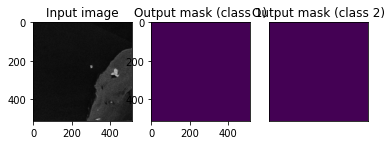

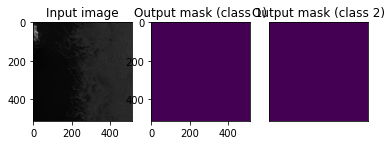

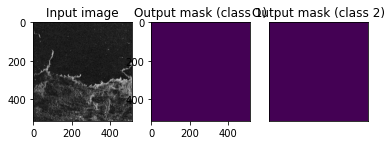

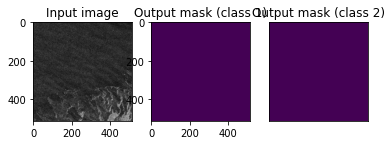

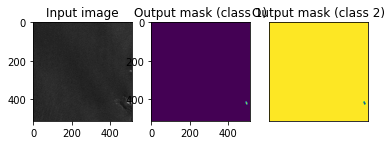

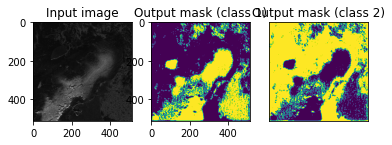

In [46]:
model_path = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/model/checkpoints/unet_orig/checkpoint_epoch1.pth')
unet_type = 'raw'
image_type = 'sar'
dir_test = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/trainingdata/testing/')
dir_out = Path('/mnt/g/Shared drives/2021-gtc-sea-ice/model/outtiles/')

test = make_predictions(model_path, unet_type, image_type, dir_test, dir_out, viz = True, save = False)